In [1]:
import pickle

import numpy as np
import pandas as pd

import seaborn as sns

In [40]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections


class Feature_engineering:
    """
    Feature engineering
    """

    def __init__(self):
        pass


    def encoder(self, df_colum_changed):

        """
        Aplica label encoder nas features categóricas
        não retorna features numéricas
        """

        explor_cut = pd.DataFrame({'nomes': df_colum_changed.columns,
                                   'tipos': df_colum_changed.dtypes, 'Nunique': df_colum_changed.nunique()})

        list_name_encoder = (list(explor_cut[explor_cut['tipos'] == 'object']['nomes']) + list(
            explor_cut[explor_cut['tipos'] == 'bool']['nomes']))
        list_name_encoder = list_name_encoder[:]
        lista_encoder = df_colum_changed[list_name_encoder]

        encoder_dict = collections.defaultdict(LabelEncoder)
        labeled_df = lista_encoder.apply(lambda x: encoder_dict[x.name].fit_transform(x))
        self.encoder_dict = encoder_dict 
        return labeled_df

    def predic_encoder(self, pred):

        labeled_pred = pred.apply(lambda x: self.encoder_dict[x.name].transform(x))

        return labeled_pred

In [3]:
import pandas as pd
from collections import Counter
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from numpy import set_printoptions
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


class Feat_select:


    def __init__(self):

        pass

    def rank(self, X, y):
        """
        Entrada de dataset de treino = X  e teste = y
        """

        X = X
        y = y
        # estimators
        rf = RandomForestClassifier()
        rf = rf.fit(X, y)
        rfe = RFE(rf, n_features_to_select=1, verbose=2)
        rfe = rfe.fit(X, y)
        rank = pd.DataFrame({'features': X.columns})
        rank['RF rank'] = rfe.ranking_

        rfr = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
        rfr.fit(X, y)
        rank['RFR'] = (rfr.feature_importances_ * 100)

        linreg = LinearRegression(normalize=True)
        linreg.fit(X, y)
        rank['linreg'] = (linreg.coef_.round(3) * 10)

        model = LogisticRegression(solver='liblinear')
        rfe = RFE(model, 3)
        rfe = rfe.fit(X, y)
        rank['logreg'] = rfe.ranking_

        etc = ExtraTreesClassifier()
        etc.fit(X, y)
        rank['etc'] = (etc.feature_importances_.round(3) * 100)

        test = SelectKBest(score_func=f_classif, k=4)
        fit = test.fit(X, y)
        set_printoptions(precision=3)
        rank['f_score'] = fit.scores_
        print(rank.sort_values('RF rank', ascending=True))

        # opções de listas de features selecionadas para cada estimador
        lista_comb_feat_RFR = []
        lista_comb_feat_RFrank = []
        lista_comb_feat_linreg = []
        lista_comb_feat_logreg = []
        lista_comb_feat_etc = []
        lista_comb_feat_f_score = []
        for x in range(2, 11):
            lista_comb_feat_RFR.append(rank.sort_values('RFR', ascending=False).head(x)['features'].tolist())
            lista_comb_feat_RFrank.append(rank.sort_values('RF rank', ascending=True).head(x)['features'].tolist())
            lista_comb_feat_linreg.append(rank.sort_values('linreg', ascending=False).head(x)['features'].tolist())
            lista_comb_feat_logreg.append(rank.sort_values('logreg', ascending=True).head(x)['features'].tolist())
            lista_comb_feat_etc.append(rank.sort_values('etc', ascending=False).head(x)['features'].tolist())
            lista_comb_feat_f_score.append(rank.sort_values('f_score', ascending=False).head(x)['features'].tolist())

        return lista_comb_feat_RFrank

    def test_feat(self, lista_features, port1, port2, port3, id1, id2, id3):
        """
        Testa uma lista de features para o modelo kmeans
        testes de 4 a 8 grupos para cada uma das combinações de features passadas na lista
        Quantile transformer > PCA a 95% > Resulta na % de recomendação da lista total
        e na % de similaridade
        """
        df_labeled = pd.read_csv('../output/df_labeled.csv')
        id_df = pd.read_csv('../output/group.csv')
        id_df = id_df['indices'].copy()

        for i in range(4, 9):

            for x in range(0, len(lista_features)):
                rep_df = df_labeled[lista_features[x]]
                rep_port1 = port1[lista_features[x]]
                rep_port2 = port2[lista_features[x]]
                rep_port3 = port3[lista_features[x]]

                # QuantileTransformerpossui um output_distribution, parâmetro adicional que permite corresponder uma distribuição gaussiana em vez de uma distribuição uniforme. Observe que esse transformador não paramétrico apresenta artefatos de saturação para valores extremos.
                QtTrsfm = QuantileTransformer()
                X = QtTrsfm.fit_transform(rep_df)
                X1 = QtTrsfm.transform(rep_port1)
                X2 = QtTrsfm.transform(rep_port2)
                X3 = QtTrsfm.transform(rep_port3)

                pca = PCA(0.95)
                pca.fit(X)

                new_feat = pca.transform(X)
                new_feat1 = pca.transform(X1)
                new_feat2 = pca.transform(X2)
                new_feat3 = pca.transform(X3)

                X = new_feat.copy()
                X1 = new_feat1.copy()
                X2 = new_feat2.copy()
                X3 = new_feat3.copy()

                k_means = KMeans(n_clusters=i, max_iter=10, n_init=30, random_state=42)
                k_means.fit(X)

                pred = k_means.predict(X)
                group = pd.DataFrame(pred)
                indice_principal = id_df.reset_index(drop=True)
                group['indices'] = indice_principal

                pred1 = k_means.predict(X1)
                pred2 = k_means.predict(X2)
                pred3 = k_means.predict(X3)

                recomender_1 = Counter(pred1)
                recomender_2 = Counter(pred2)
                recomender_3 = Counter(pred3)

                
                # retorna o grupo mais frequente de cada empresa
                leads_port1 = group[group[0] == recomender_1.most_common(1)[0][0]]['indices']
                leads_port1 = leads_port1.append(group[group[0] == recomender_1.most_common()[1][0]]['indices'])

                leads_port2 = group[group[0] == recomender_2.most_common(1)[0][0]]['indices']

                leads_port3 = group[group[0] == recomender_3.most_common(1)[0][0]]['indices']

                lista_resultados_RFrank = []
                
                # avaliação da % do tamanho da recomendação, quantos % do total da lista foi recomendado
                rec1 = round(len(leads_port1) / len(group) * 100, 2)
                rec2 = round(len(leads_port2) / len(group) * 100, 2)
                rec3 = round(len(leads_port3) / len(group) * 100, 2)
                
                # avaliaçã da similaridade, confere quantos % da recomendação já é cliente
                sim1 = round(len(id1.loc[id1.isin(leads_port1)]) / len(id1) * 100, 2)
                sim2 = round(len(id2.loc[id2.isin(leads_port2)]) / len(id2) * 100, 2)
                sim3 = round(len(id3.loc[id3.isin(leads_port3)]) / len(id3) * 100, 2)

                lista_resultados_RFrank.append(
                    f'média de recomendação :{round((rec1 + rec2 + rec3) / 3, 2)}%- média similar :{round((sim1 + sim2 + sim3) / 3, 2)}% Nº grupos :{i}- comb feat :{x}')

                print(lista_resultados_RFrank)
                print('--------------------------------------------------------------------------------')

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
              ('LogReg', LogisticRegression()), 
              ('RF', RandomForestClassifier()),
              ('KNN', KNeighborsClassifier()),
              ('SVM', SVC()), 
              ('GNB', GaussianNB()),
              ('XGB', XGBClassifier())
        ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['malignant', 'benign']
    for name, model in models:   
        
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
    return final

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

class Model_select:
    """
    Pré-processamento dos dados
    """

    def __init__(self):
        pass

    def testing_hip_par(self, X_train, y_train):
        """
        Mostra a melhor pontuação AUC de cada modelo após testes de vários hiperparâmetros
        Entrada é o X_train e y_train
        Pode ser lento
        Produzido para problemas de classificação
        """
        # hiperparâmetros para RFC
        n_estimators = [200,300]
        criterion = ['gini', 'entropy']
        param_grid = dict(n_estimators = n_estimators, criterion = criterion )
        rfc = RandomForestClassifier()
        grid = GridSearchCV(estimator=rfc, param_grid = param_grid, scoring='roc_auc',
                            verbose=1, n_jobs=-1, refit=True)
        grid_result = grid.fit(X_train, y_train)
        print('--------------------------------------------------------------------')
        print('Random Forest')
        print('Best Score:' , grid_result.best_score_.round(2))
        print('Best Params:' , grid_result.best_params_)

        # hiperparâmetros para Logistic regression
        C = [1,5,10,50,100]
        penalty = ['l1', 'l2']
        param_grid = dict(C = C, penalty = penalty )
        logreg = LogisticRegression()
        grid = GridSearchCV(estimator=logreg, param_grid = param_grid, scoring='roc_auc',
                            verbose=1, n_jobs=-1, refit = True)
        grid_result = grid.fit(X_train, y_train)
        print('--------------------------------------------------------------------')
        print('Logistic Regression')
        print('Best Score:' , grid_result.best_score_.round(2))
        print('Best Params:' , grid_result.best_params_)

        # hiperparâmetros para Extra tree classifier
        n_estimators = [100,200,300]
        criterion = ["gini", "entropy"]
        max_features = ["auto", "sqrt", "log2"]
        param_grid = dict(n_estimators = n_estimators, criterion = criterion, max_features = max_features )
        etc = ExtraTreesClassifier()
        grid = GridSearchCV(estimator=etc, param_grid = param_grid, scoring='roc_auc',
                            verbose=1, n_jobs=-1, refit = True)
        grid_result = grid.fit(X_train, y_train)
        print('--------------------------------------------------------------------')
        print('Extra tree classifier')
        print('Best Score:' , grid_result.best_score_.round(2))
        print('Best Params:' , grid_result.best_params_)

        # hiperparâmetros para Knn
        n_neighbors = [2,5,10,15,20]
        weights = ['uniform', 'distance']
        algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
        param_grid = dict(n_neighbors = n_neighbors, weights = weights, algorithm = algorithm )
        knn = KNeighborsClassifier()
        grid = GridSearchCV(estimator=knn, param_grid = param_grid, scoring='roc_auc',
                            verbose=1, n_jobs=-1, refit = True)
        grid_result = grid.fit(X_train, y_train)
        print('--------------------------------------------------------------------')
        print('Knn')
        print('Best Score:' , grid_result.best_score_.round(2))
        print('Best Params:' , grid_result.best_params_)

        # hiperparâmetros para Decision of Tree
        criterion = ["gini", "entropy"]
        splitter = ["best", "random"]
        param_grid = dict(criterion = criterion, splitter = splitter)
        decision_tree = DecisionTreeClassifier()
        grid = GridSearchCV(estimator=decision_tree, param_grid = param_grid, scoring='roc_auc',
                            verbose=1, n_jobs=-1, refit = True)
        grid_result = grid.fit(X_train, y_train)
        print('--------------------------------------------------------------------')
        print('Decision of Tree')
        print('Best Score:' , grid_result.best_score_.round(2))
        print('Best Params:' , grid_result.best_params_)

        # hiperparâmetros para bagging_dec_tree
        n_estimators = [2,5,10]#,20,100,300,500]
        max_samples = [10,50] #,100,200]
        max_features = [2,3,4,5,6,7,8]
        param_grid = dict(n_estimators = n_estimators, max_samples = max_samples, max_features=max_features)
        bagging_dec_tree = BaggingClassifier(DecisionTreeClassifier(), bootstrap=True)
        grid = GridSearchCV(estimator=bagging_dec_tree, param_grid = param_grid, scoring='roc_auc',
                            verbose=1, n_jobs=-1, refit = True)
        grid_result = grid.fit(X_train, y_train)
        print('--------------------------------------------------------------------')
        print('bagging_dec_tree')
        print('Best Score:' , grid_result.best_score_.round(2))
        print('Best Params:' , grid_result.best_params_)

        # hiperparâmetros para bagging_RFC
        n_estimators = [2,5,10,20] #,100,300,500]
        max_samples = [5,10,20]#,50,100,200]
        max_features = [2,3,4,5,6,7,8]
        param_grid = dict(n_estimators = n_estimators, max_samples = max_samples, max_features=max_features)
        bagging_RFC = BaggingClassifier(RandomForestClassifier(), bootstrap=True) # roda 300 modelos e cada modelo roda 100 x com   #amostras buscadas aleatoriamente
        grid = GridSearchCV(estimator=bagging_RFC, param_grid = param_grid, scoring='roc_auc',
                            verbose=1, n_jobs=-1, refit = True)
        grid_result = grid.fit(X_train, y_train)
        print('--------------------------------------------------------------------')
        print('bagging_RFC')
        print('Best Score:' , grid_result.best_score_.round(2))
        print('Best Params:' , grid_result.best_params_)

        # hiperparâmetros para SVC
        C = [1,2,5,10,20]
        gamma = ['scale', 'auto']
        param_grid = dict(C = C, gamma=gamma)
        svc_model = SVC(probability=True)
        grid = GridSearchCV(estimator=svc_model, param_grid = param_grid, scoring='roc_auc',
                            verbose=1, n_jobs=-1, refit = True)
        grid_result = grid.fit(X_train, y_train)
        print('--------------------------------------------------------------------')
        print('SVC')
        print('Best Score:' , grid_result.best_score_.round(2))
        print('Best Params:' , grid_result.best_params_)

        # hiperparâmetros para gnb

        var_smoothing = [1e-09,1e-08,1e-07]
        param_grid = dict(var_smoothing = var_smoothing)
        gnb = GaussianNB()
        grid = GridSearchCV(estimator=gnb, param_grid = param_grid, scoring='roc_auc',
                            verbose=1, n_jobs=-1, refit = True)
        grid_result = grid.fit(X_train, y_train)
        print('--------------------------------------------------------------------')
        print('GNB NAIVE BAYES')
        print('Best Score:' , grid_result.best_score_.round(2))
        print('Best Params:' , grid_result.best_params_)
        
        # hiperparâmetros para XGBClassifier
        
        estimator = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=42)
        parameters = {'max_depth': range (2, 10, 1),'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}
        grid = GridSearchCV(estimator=estimator, param_grid=parameters, scoring = 'roc_auc', n_jobs = 10, cv = 10, verbose=True)

        grid_result = grid.fit(X_train, y_train)

        # grid_result.best_estimator_  ( para saber todos hiperparametros)
        print('--------------------------------------------------------------------')
        print('XGBClassifier')
        print('Best Score:' , grid_result.best_score_.round(2))
        print('Best Params:' , grid_result.best_params_)


In [47]:
df = pickle.load(open("../data/df_age_filled.p", "rb"))
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,male,27.0,0,0,330877,8.4583,Q
1,1,2,male,34.0,0,0,244373,13.0000,S
2,1,3,female,27.0,0,0,2649,7.2250,C
3,0,3,male,27.0,0,0,2631,7.2250,C
4,1,3,female,27.0,0,0,330959,7.8792,Q


Encoding values of categorical features

In [48]:
fe = Feature_engineering()
labeled_df = fe.encoder(df[['Sex','Embarked']])

In [49]:
df = df.drop(['Sex','Embarked'],axis=1)
df = pd.concat([df,labeled_df],axis=1)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Sex,Embarked
0,0,3,27.0,0,0,330877,8.4583,1,1
1,1,2,34.0,0,0,244373,13.0000,1,2
2,1,3,27.0,0,0,2649,7.2250,0,0
3,0,3,27.0,0,0,2631,7.2250,1,0
4,1,3,27.0,0,0,330959,7.8792,0,1


 # Ranking of feature importance using multiple models

In [13]:
X = df[['Sex','Embarked','Age','Pclass','SibSp','Parch','Fare']]
y = df['Survived']

In [8]:
lista_features  = Feat_select().rank(X,y)

Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50building tree 2 of 50

building tree 3 of 50building tree 4 of 50

building tree 5 of 50building tree 6 of 50

building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50building tree 13 of 50
building tree 14 of 50

building tree 15 of 50building tree 16 of 50

building tree 17 of 50
building tree 18 of 50building tree 19 of 50

building tree 20 of 50
building tree 21 of 50building tree 22 of 50building tree 23 of 50


building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50

building tree 32 of 50building tree 33 of 50

building tree 34 of 50
building tree 35 of 50building tree 36 of 50building tree 37 of 50

building tree 38 of 50
building tree 39 of 50
building tree 40 of 50

building tree 41 of 50
building tree 42 of 50
building tree 43 of 50building tree 44 of 5

C:\Users\lrocha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [15]:
df.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked
Survived,1.000000,-0.338481,-0.041539,-0.035322,0.081629,0.257307,-0.543351,-0.167675
Pclass,-0.338481,1.000000,-0.408259,0.083081,0.018443,-0.549500,0.131900,0.162098
Age,-0.041539,-0.408259,1.000000,-0.340785,-0.219072,0.103528,0.098818,-0.033147
SibSp,-0.035322,0.083081,-0.340785,1.000000,0.414838,0.159651,-0.114631,0.068230
Parch,0.081629,0.018443,-0.219072,0.414838,1.000000,0.216225,-0.245489,0.039798
Fare,0.257307,-0.549500,0.103528,0.159651,0.216225,1.000000,-0.182333,-0.224719
Sex,-0.543351,0.131900,0.098818,-0.114631,-0.245489,-0.182333,1.000000,0.108262
Embarked,-0.167675,0.162098,-0.033147,0.068230,0.039798,-0.224719,0.108262,1.000000


# evaluating some models

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=7)

In [65]:
final = run_exps(X_train,y_train,X_test,y_test)

LogReg
              precision    recall  f1-score   support

   malignant       0.81      0.89      0.84       168
      benign       0.77      0.64      0.70       100

    accuracy                           0.79       268
   macro avg       0.79      0.76      0.77       268
weighted avg       0.79      0.79      0.79       268

RF
              precision    recall  f1-score   support

   malignant       0.84      0.89      0.86       168
      benign       0.79      0.72      0.75       100

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268

KNN
              precision    recall  f1-score   support

   malignant       0.79      0.80      0.79       168
      benign       0.65      0.64      0.65       100

    accuracy                           0.74       268
   macro avg       0.72      0.72      0.72       268
weighted avg       0.74      0.74      0.74       268

SVM
 

In [66]:
final

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,0.030891,0.008979,0.768000,0.769775,0.768000,0.768836,0.771930,LogReg
1,0.023935,0.006981,0.840000,0.838729,0.840000,0.838444,0.894026,LogReg
2,0.020943,0.005984,0.832000,0.831626,0.832000,0.830415,0.871754,LogReg
3,0.018949,0.005984,0.814516,0.813864,0.814516,0.812807,0.875504,LogReg
4,0.022938,0.004986,0.790323,0.790770,0.790323,0.788642,0.851647,LogReg
5,0.264322,0.022924,0.752000,0.757951,0.752000,0.754533,0.759528,RF
6,0.127671,0.022943,0.872000,0.871437,0.872000,0.870756,0.909029,RF
7,0.137606,0.021941,0.784000,0.784186,0.784000,0.779739,0.891627,RF
8,0.133641,0.021940,0.782258,0.782973,0.782258,0.782564,0.860731,RF
9,0.156609,0.022939,0.774194,0.774299,0.774194,0.772384,0.827800,RF


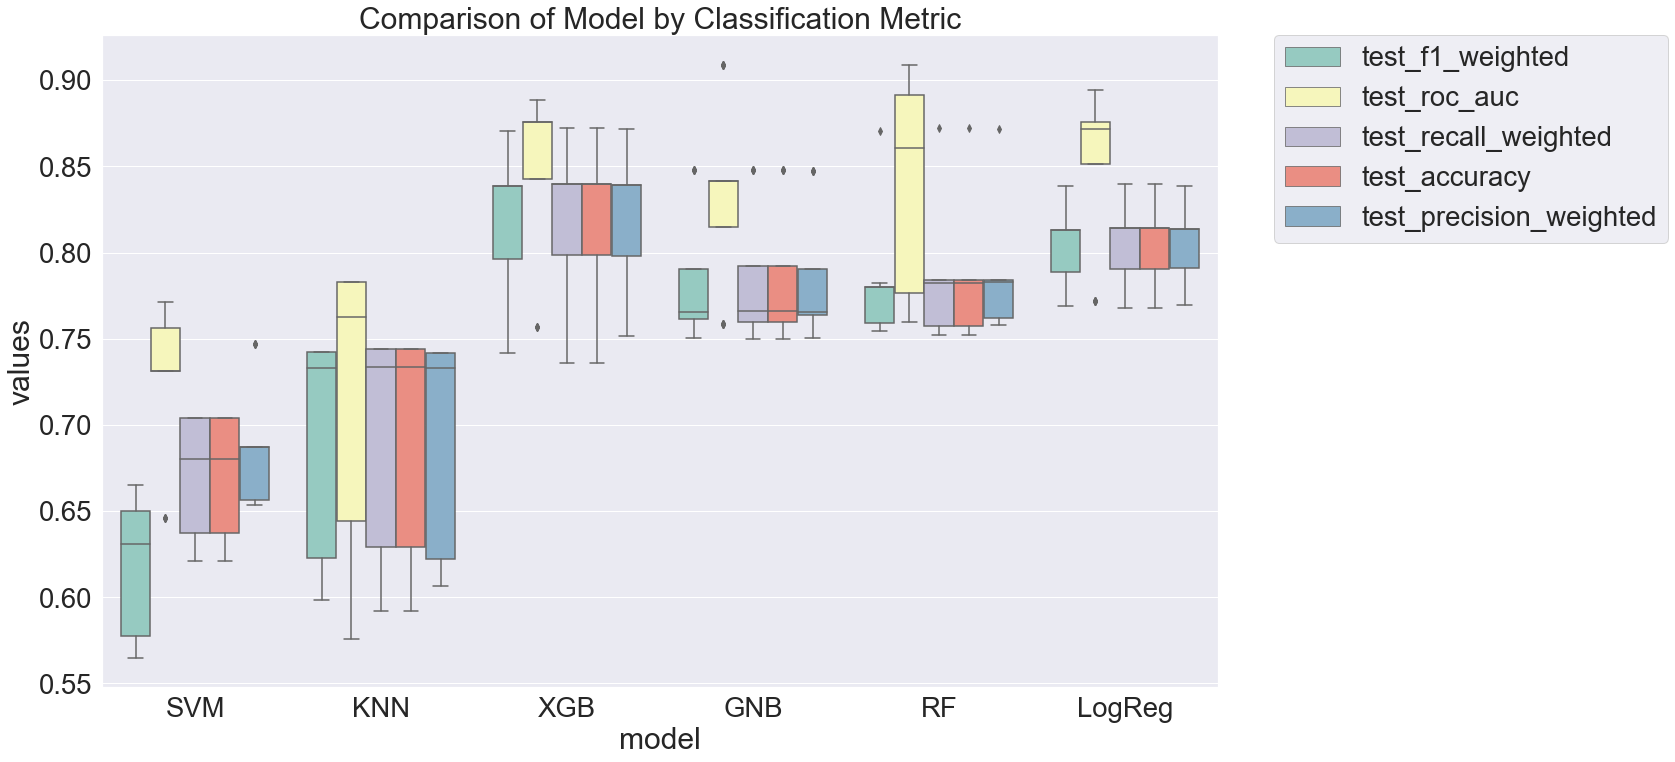

In [68]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

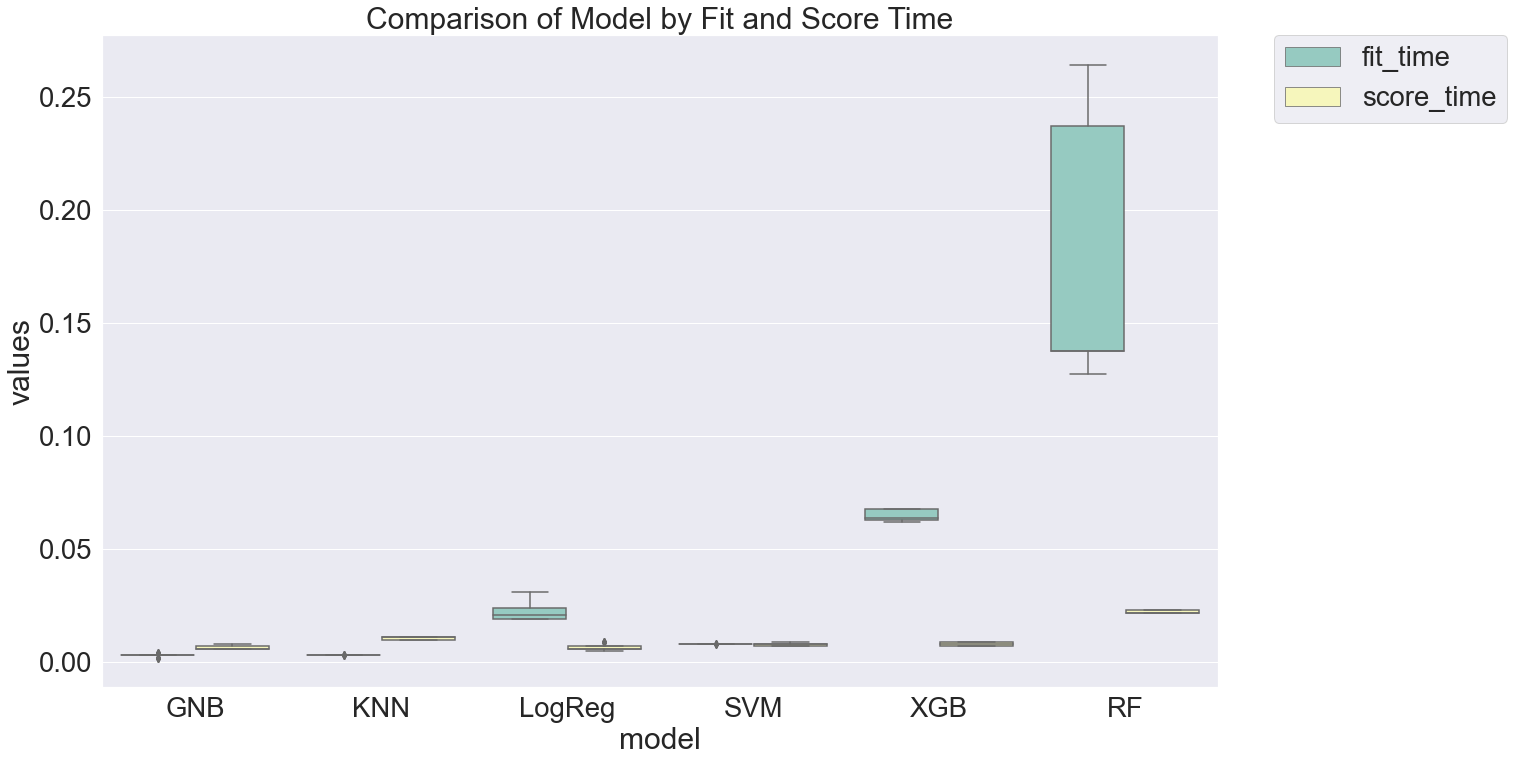

In [69]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

In [70]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_precision_weighted           test_roc_auc           test_accuracy  \
                           std      mean          std      mean           std   
model                                                                           
GNB                   0.033064  0.787198     0.051304  0.829451      0.033945   
KNN                   0.061900  0.686834     0.087461  0.709094      0.066831   
LogReg                0.023759  0.804346     0.043925  0.847970      0.024729   
RF                    0.020798  0.778208     0.054629  0.840164      0.022522   
SVM                   0.031639  0.684171     0.040590  0.729104      0.031531   
XGB                   0.038413  0.820606     0.041864  0.851818      0.042777   

                 test_recall_weighted           test_f1_weighted            
            mean                  std      mean              std      mean  
model                                                                       
GNB     0.786897             0.033945  0.786897         0.033491  0.786750  
KNN     0.685116             0.066831  0.685116         0.064586  0.685026  
LogReg  0.804243             0.024729  0.804243         0.023874  0.803163  
RF      0.776417             0.022522  0.776417         0.021268  0.775391  
SVM     0.672441             0.031531  0.672441         0.036315  0.621621  
XGB     0.818662             0.042777  0.818662         0.041119  0.818129

# Now we know the XGBClassifier model is best model for this problem when we look for this metrics of evaluation

In [25]:
Model_select().testing_hip_par(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.9s finished


--------------------------------------------------------------------
Random Forest
Best Score: 0.85
Best Params: {'criterion': 'entropy', 'n_estimators': 200}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


--------------------------------------------------------------------
Logistic Regression
Best Score: 0.87
Best Params: {'C': 50, 'penalty': 'l2'}
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.1s finished


--------------------------------------------------------------------
Extra tree classifier
Best Score: 0.83
Best Params: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 200}
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


--------------------------------------------------------------------
Knn
Best Score: 0.75
Best Params: {'algorithm': 'auto', 'n_neighbors': 15, 'weights': 'distance'}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
--------------------------------------------------------------------
Decision of Tree
Best Score: 0.76
Best Params: {'criterion': 'entropy', 'splitter': 'best'}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 195 out of 210 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


--------------------------------------------------------------------
bagging_dec_tree
Best Score: 0.84
Best Params: {'max_features': 7, 'max_samples': 50, 'n_estimators': 10}
Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 405 out of 420 | elapsed:  2.8min remaining:    6.2s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  2.9min finished


--------------------------------------------------------------------
bagging_RFC
Best Score: 0.85
Best Params: {'max_features': 6, 'max_samples': 20, 'n_estimators': 20}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.0s finished


--------------------------------------------------------------------
SVC
Best Score: 0.81
Best Params: {'C': 20, 'gamma': 'scale'}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
--------------------------------------------------------------------
GNB NAIVE BAYES
Best Score: 0.84
Best Params: {'var_smoothing': 1e-09}
Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   26.4s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   46.3s


[10:04:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Score: 0.88
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed:   59.2s finished


In [31]:
from xgboost import XGBClassifier
# fit model no training data
model = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=42,learning_rate = 0.05, max_depth = 3, n_estimators = 100)
model.fit(X_train, y_train)

[10:20:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [33]:
grid_result.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC: %.2f%%" % roc_auc_score(y_test, predictions))


Accuracy: 82.09%
ROC AUC: 0.78%


# Try first prediction

In [83]:
test = pd.read_csv(r'C:/Users/lrocha/Documents/Kaggle/Titanic/data/test.csv', encoding="utf-8", sep=',',decimal='.')

In [18]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [19]:
pd.read_csv(r'C:/Users/lrocha/Documents/Kaggle/Titanic/gender_submission.csv', encoding="utf-8", sep=',',decimal='.')

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Need fill na values with same model used on Age

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [50]:
labeled_predicted = fe.predic_encoder(test[['Sex','Embarked']])

In [84]:
test = test.drop(['Sex','Embarked','Name','Ticket','Cabin'],axis=1)
test = pd.concat([test,labeled_predicted],axis=1)

In [85]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked
0,892,3,34.5,0,0,7.8292,1,1
1,893,3,47.0,1,0,7.0000,0,2
2,894,2,62.0,0,0,9.6875,1,1
3,895,3,27.0,0,0,8.6625,1,2
4,896,3,22.0,1,1,12.2875,0,2


In [53]:
test['Age'].mean()

30.272590361445783

Fill with mean and after test fill with predict values

In [135]:
test = test.fillna(30)

In [136]:
test[['Sex', 'Embarked', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare']]

,Sex,Embarked,Age,Pclass,SibSp,Parch,Fare
0,1,1,34.5,3,0,0,7.8292
1,0,2,47.0,3,1,0,7.0000
2,1,1,62.0,2,0,0,9.6875
3,1,2,27.0,3,0,0,8.6625
4,0,2,22.0,3,1,1,12.2875
...,...,...,...,...,...,...,...
413,1,2,30.0,3,0,0,8.0500
414,0,0,39.0,1,0,0,108.9000
415,1,2,38.5,3,0,0,7.2500
416,1,2,30.0,3,0,0,8.0500


In [137]:
pred = model.predict(test[['Sex', 'Embarked', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare']])

In [138]:
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [140]:
test['Survived'] = pred

In [143]:
Survived = test[['PassengerId','Survived']]

In [146]:
Survived.to_csv(r'C:/Users/lrocha/Documents/Kaggle/Titanic/data/Survived.csv',index=False,sep=',')

In [145]:
Survived

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# 78% on Kaggle

# predict Age on test dataset using the previously model used to predict the age on trainig dataset

In [61]:
from joblib import dump, load
model = load('modelo.pkl')

In [62]:
model

{'scaler': QuantileTransformer(),
 'pca': PCA(n_components=0.95),
 'modelo': RandomForestRegressor(n_estimators=1000, random_state=42)}

In [88]:
test_age_na_1 = test.loc[test['Age'].isna()]
test_age_na_0 = test.loc[~test['Age'].isna()]

In [89]:
X_scaled = model['scaler'].transform(test_age_na_1[['Pclass','SibSp','Parch']])
pca = model['pca'].transform(X_scaled)
predict = model['modelo'].predict(pca)

In [90]:
predict

array([14.56569812, 14.63989834, 28.83133465,  7.067164  , 14.56569812,
       14.56569812, 14.63989834, 14.56569812, 14.58901181, 28.85314904,
       14.58901181, 14.56569812, 14.56569812, 14.58901181, 28.85314904,
       14.56569812, 14.56569812, 14.56569812, 14.56569812, 14.56569812,
       14.56569812, 14.56569812, 14.56569812, 28.85314904, 14.56569812,
       28.83133465, 15.73773693, 28.85314904, 14.63989834, 14.63989834,
       14.56569812, 14.56569812, 14.56569812, 14.63989834, 14.56569812,
       14.56569812, 14.56569812,  6.36795275, 14.63989834, 14.56569812,
       14.56569812, 14.63989834, 14.56569812, 14.56569812, 14.56569812,
       15.73773693, 14.56569812, 14.56569812, 14.56569812,  7.067164  ,
       28.85314904, 14.56569812, 14.56569812, 14.56569812, 14.63989834,
       14.56569812, 14.56569812, 14.56569812, 28.85314904, 14.56569812,
       14.56569812, 14.56569812, 14.56569812, 14.56569812, 14.63989834,
       14.56569812, 28.83133465, 14.58901181, 14.56569812, 14.56

In [95]:
test_age_na_1['Age'] = predict.astype(int)

In [96]:
test_age_na_1

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked
10,902,3,14,0,0,7.8958,1,2
22,914,1,14,0,0,31.6833,0,2
29,921,3,28,2,0,21.6792,1,0
33,925,3,7,1,2,23.4500,0,2
36,928,3,14,0,0,8.0500,0,2
...,...,...,...,...,...,...,...,...
408,1300,3,14,0,0,7.7208,0,1
410,1302,3,14,0,0,7.7500,0,1
413,1305,3,14,0,0,8.0500,1,2
416,1308,3,14,0,0,8.0500,1,2


In [99]:
test_predict_age = pd.concat([test_age_na_1,test_age_na_0])

In [100]:
test_predict_age

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked
10,902,3,14.0,0,0,7.8958,1,2
22,914,1,14.0,0,0,31.6833,0,2
29,921,3,28.0,2,0,21.6792,1,0
33,925,3,7.0,1,2,23.4500,0,2
36,928,3,14.0,0,0,8.0500,0,2
...,...,...,...,...,...,...,...,...
409,1301,3,3.0,1,1,13.7750,0,2
411,1303,1,37.0,1,0,90.0000,0,1
412,1304,3,28.0,0,0,7.7750,0,2
414,1306,1,39.0,0,0,108.9000,0,0


In [101]:
from xgboost import XGBClassifier
# fit model no training data
model = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=42,learning_rate = 0.05, max_depth = 3, n_estimators = 100)
model.fit(X_train, y_train)

[10:42:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [104]:
pred = model.predict(test_predict_age[['Sex','Embarked','Age','Pclass','SibSp','Parch','Fare']])

In [102]:
X_train

,Sex,Embarked,Age,Pclass,SibSp,Parch,Fare
16,1,1,2.0,3,4,1,29.1250
15,0,2,55.0,2,0,0,16.0000
679,1,0,36.0,1,0,1,512.3292
442,1,2,25.0,3,1,0,7.7750
132,1,2,42.0,1,0,0,0.0000
...,...,...,...,...,...,...,...
505,1,0,18.0,1,1,0,108.9000
403,1,2,28.0,3,1,0,15.8500
448,0,0,5.0,3,2,1,19.2583
22,0,1,15.0,3,0,0,8.0292


In [105]:
test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked
0,892,3,34.5,0,0,7.8292,1,1
1,893,3,47.0,1,0,7.0000,0,2
2,894,2,62.0,0,0,9.6875,1,1
3,895,3,27.0,0,0,8.6625,1,2
4,896,3,22.0,1,1,12.2875,0,2
...,...,...,...,...,...,...,...,...
413,1305,3,NaN,0,0,8.0500,1,2
414,1306,1,39.0,0,0,108.9000,0,0
415,1307,3,38.5,0,0,7.2500,1,2
416,1308,3,NaN,0,0,8.0500,1,2


In [106]:
test['Survived'] = pred
Survived = test[['PassengerId','Survived']]
Survived.to_csv(r'C:/Users/lrocha/Documents/Kaggle/Titanic/data/Survived.csv',index=False,sep=',')

In [107]:
Survived

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,1
414,1306,1
415,1307,0
416,1308,1


# 53 % on Kaggle

# Create a new model for predict age

Next steps: try to predict Age values and test best combination of features for this model

In [17]:
# Trying multiple combination of features
lista_features

[['Fare', 'Age'],
 ['Fare', 'Age', 'Sex'],
 ['Fare', 'Age', 'Sex', 'Pclass'],
 ['Fare', 'Age', 'Sex', 'Pclass', 'SibSp'],
 ['Fare', 'Age', 'Sex', 'Pclass', 'SibSp', 'Parch'],
 ['Fare', 'Age', 'Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked'],
 ['Fare', 'Age', 'Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked'],
 ['Fare', 'Age', 'Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked'],
 ['Fare', 'Age', 'Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked']]

In [ ]:
# Testing multiple combination of features using AUC method with parameter of comparison
Feat_select().test_feat(lista_features, df_quantil_change)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))